## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Define path

path = r'/Users/vanessanunezpenas/Documents/Data Analysis Projects/Airbnb Berlin Ratings'

In [3]:
# Import Airbnb Berlin data

berlin = pd.read_csv(os.path.join(path,'2. Data', 'Prepared','airbnb_berlin_clean.csv'))

## Data preparation

In [4]:
berlin.columns

Index(['Review ID', 'Review Date', 'Reviewer ID', 'Listing ID', 'Host ID',
       'Host Since', 'Host Response Time', 'Host Response Rate',
       'Is Superhost', 'Neighborhood Group', 'Postal Code', 'Latitude',
       'Longitude', 'Is Exact Location', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Guests Included', 'Min Nights', 'Reviews', 'First Review',
       'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Instant Bookable',
       'Business Travel Ready'],
      dtype='object')

In [5]:
sub_berlin = berlin[['Review Date', 'Reviews', 'Reviewer ID', 'Listing ID']]

In [6]:
sub_berlin.head()

,Review Date,Reviews,Reviewer ID,Listing ID
0,2016-01-03,1,14876562,10002699
1,2016-01-03,20,49367757,10006647
2,2016-01-05,20,46694292,10006647
3,2016-03-25,20,54542819,10006647
4,2016-04-01,20,35352843,10006647


In [7]:
sub_berlin.shape

(451600, 4)

In [8]:
sub_berlin.isnull().sum()

Review Date    0
Reviews        0
Reviewer ID    0
Listing ID     0
dtype: int64

In [9]:
sub_berlin['Review Date'].min()

'2009-06-20'

In [10]:
sub_berlin['Review Date'].max()

'2019-05-14'

In [11]:
sub_berlin['Reviews'].sum()

47008872

In [12]:
sub_berlin['Reviews'].min()

1

In [13]:
sub_berlin['Reviews'].max()

545

In [14]:
sub_berlin['Reviews'].mean()

104.09404782993799

The values in the Reviews column refer to the total number of reviews that that same listing has. For the purpose of our current analysis, we will let only one review for reviewer ID by listing and date. 

In [15]:
sub_berlin['Reviews'].mask(sub_berlin['Reviews'] > 1, 1, inplace=True)

In [16]:
sub_berlin['Reviews'].max()

1

In [17]:
sub_berlin.head()

,Review Date,Reviews,Reviewer ID,Listing ID
0,2016-01-03,1,14876562,10002699
1,2016-01-03,1,49367757,10006647
2,2016-01-05,1,46694292,10006647
3,2016-03-25,1,54542819,10006647
4,2016-04-01,1,35352843,10006647


In [18]:
# Check for duplicates

dups = sub_berlin.duplicated()
dups.sum()

# There are 14 dups we need to delete

14

In [19]:
# Dropping duplicate values 

sub_berlin.drop_duplicates(keep=False, inplace=True) 

In [20]:
sub_berlin.shape

(451572, 4)

In [21]:
sub_berlin['Reviews'].sum()

451572

In [22]:
# Dropping the columns Reviewer ID and Listing ID because we don't need them anymore

sub_berlin = sub_berlin.drop(columns = ['Reviewer ID','Listing ID'])

In [23]:
# Set the "Review Date" column as the index

from datetime import datetime


sub_berlin['datetime'] = pd.to_datetime(sub_berlin['Review Date'])
sub_berlin = sub_berlin.set_index('datetime')
sub_berlin.drop(['Review Date'], axis=1, inplace=True)
sub_berlin.head()

,Reviews
datetime,
2016-01-03,1
2016-01-03,1
2016-01-05,1
2016-03-25,1
2016-04-01,1


In [24]:
sub_berlin['Reviews'].sum()

451572

In [25]:
# Resample to monthly reviews sum and save as new dataframe

reviews_monthly = sub_berlin.resample('M').sum()
reviews_monthly

,Reviews
datetime,
2009-06-30,1
2009-07-31,0
2009-08-31,1
2009-09-30,0
2009-10-31,0
...,...
2019-01-31,12964
2019-02-28,12950
2019-03-31,16613


In [26]:
# Checking we have the same total number of reviews

reviews_monthly['Reviews'].sum()

451572

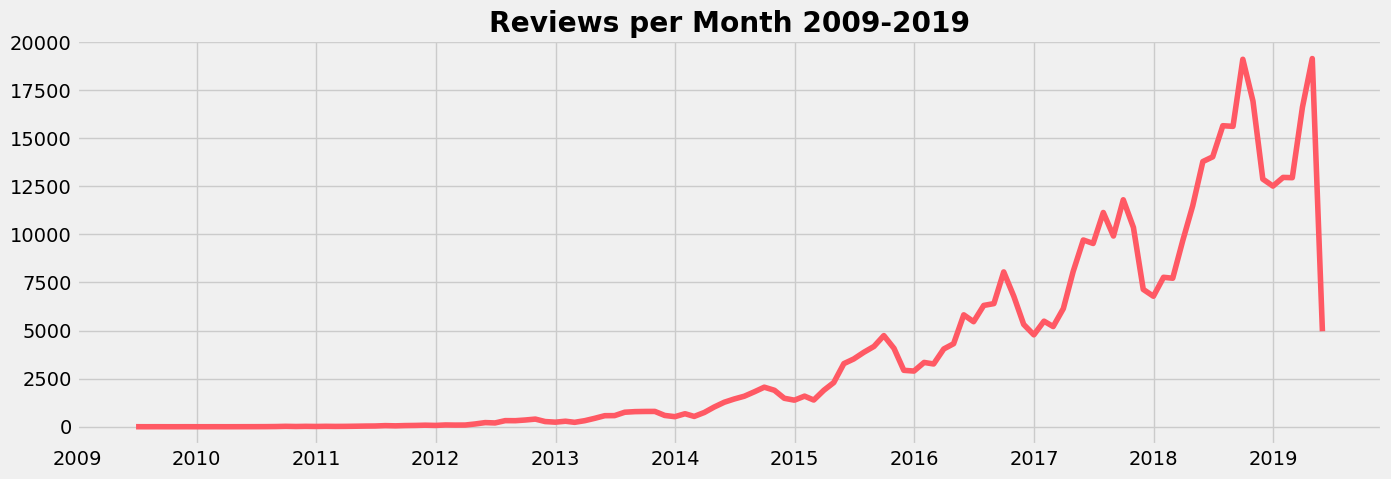

In [27]:
# Plot the data set

plt.figure(figsize=(15, 5), dpi=100)
time_series_reviews = plt.title('Reviews per Month 2009-2019', fontweight='bold')
plt.plot(reviews_monthly, color='#FF5964')

After cleaning and plotting the data, we can see perfectly how the Airbnb market in Berlin started its boom in 2014. Considering the size of the data and this characteristic, we can subset the data for the last five years, from 2014 to 2019. 

In [28]:
# Reset index so that you can use the "Review Date" column as a filter

sub_2 = reviews_monthly.reset_index()

In [29]:
sub_2.head()

,datetime,Reviews
0,2009-06-30,1
1,2009-07-31,0
2,2009-08-31,1
3,2009-09-30,0
4,2009-10-31,0


In [30]:
data_sub = sub_2.loc[(sub_2['datetime'] >= '2014-01-01') & (sub_2['datetime'] < '2019-05-14')]

In [31]:
data_sub.shape

(64, 2)

In [32]:
data_sub.head()

,datetime,Reviews
55,2014-01-31,676
56,2014-02-28,536
57,2014-03-31,742
58,2014-04-30,1024
59,2014-05-31,1274


In [33]:
# Set the "datetime" column as the index again

data_sub = data_sub.set_index('datetime')
data_sub.head()

,Reviews
datetime,
2014-01-31,676
2014-02-28,536
2014-03-31,742
2014-04-30,1024
2014-05-31,1274


## Time-series analysis: decomposition

In [34]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [35]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

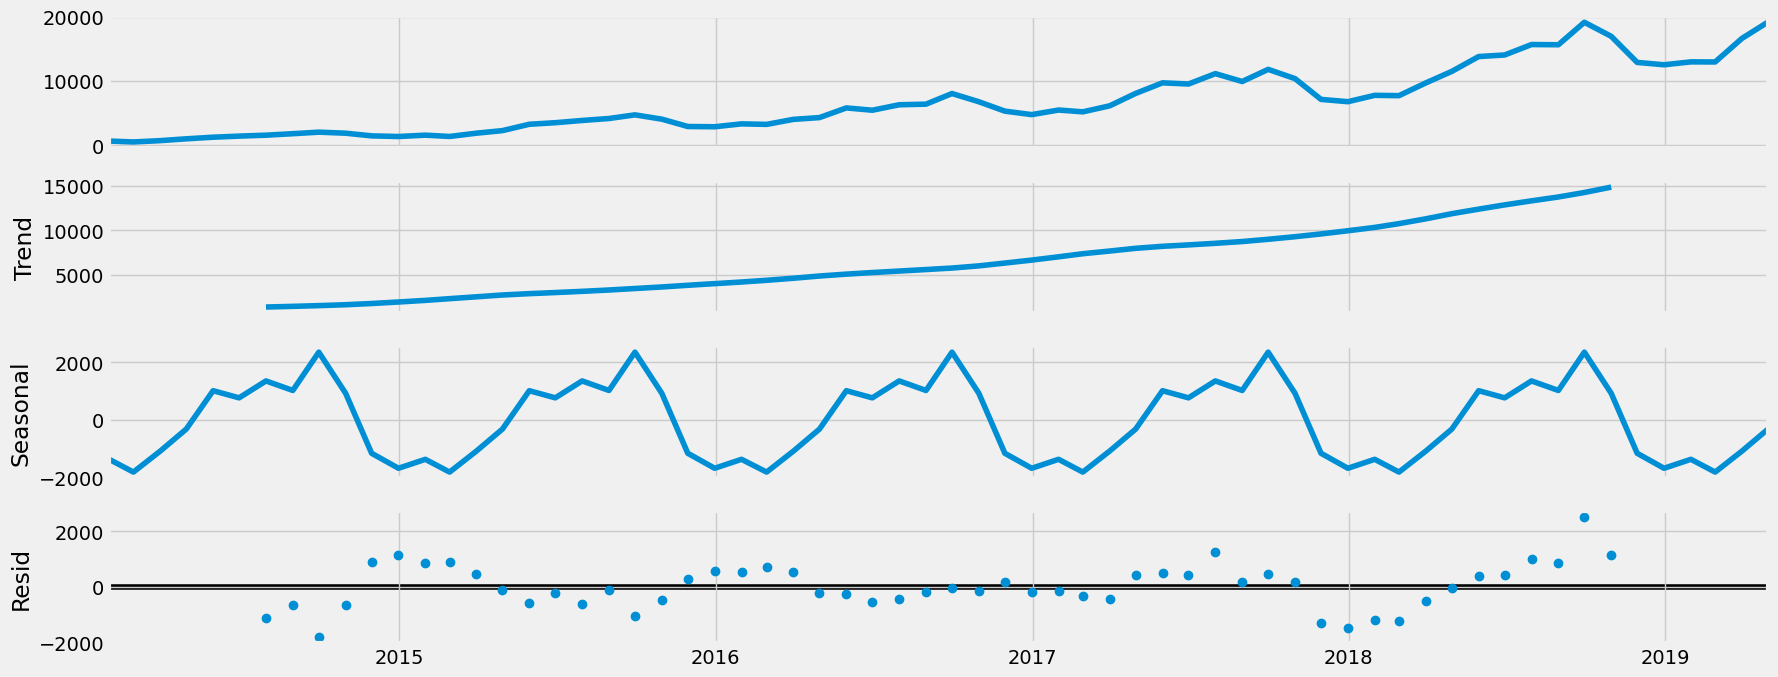

In [36]:
# Plot the separate components

decomposition.plot()
plt.show()

We can see an upward trend line for the selected period and a pattern that repeats itself periodically at the same time each year, showing seasonality in the data. There are fewer reviews at the beginning of each year and a prominent peak around the third quarter of every year coinciding with the summer. The residual line, the noise of the data, has some up-and-down deviations that we will need to smooth. 

## Dickey-Fuller test to check for stationarity

In [37]:
from statsmodels.tsa.stattools import adfuller

# Define the function:
def dickey_fuller(timeseries): 
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Reviews'])

Dickey-Fuller Stationarity test:
Test Statistic                  8.467282
p-value                         1.000000
Number of Lags Used            11.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


The p-value is 1.0, much higher than 0.05, which indicates that the test is not significant at all. The test statistic is 8.47, which is much larger than the critical values. This means that we can’t reject the null hypothesis and that the data is non-stationary. 

## Differencing

In [38]:
data_diff = data_sub - data_sub.shift(1)

In [39]:
data_diff.dropna(inplace = True) 

In [40]:
data_diff.head()

,Reviews
datetime,
2014-02-28,-140.0
2014-03-31,206.0
2014-04-30,282.0
2014-05-31,250.0
2014-06-30,167.0


In [41]:
data_diff.columns

Index(['Reviews'], dtype='object')

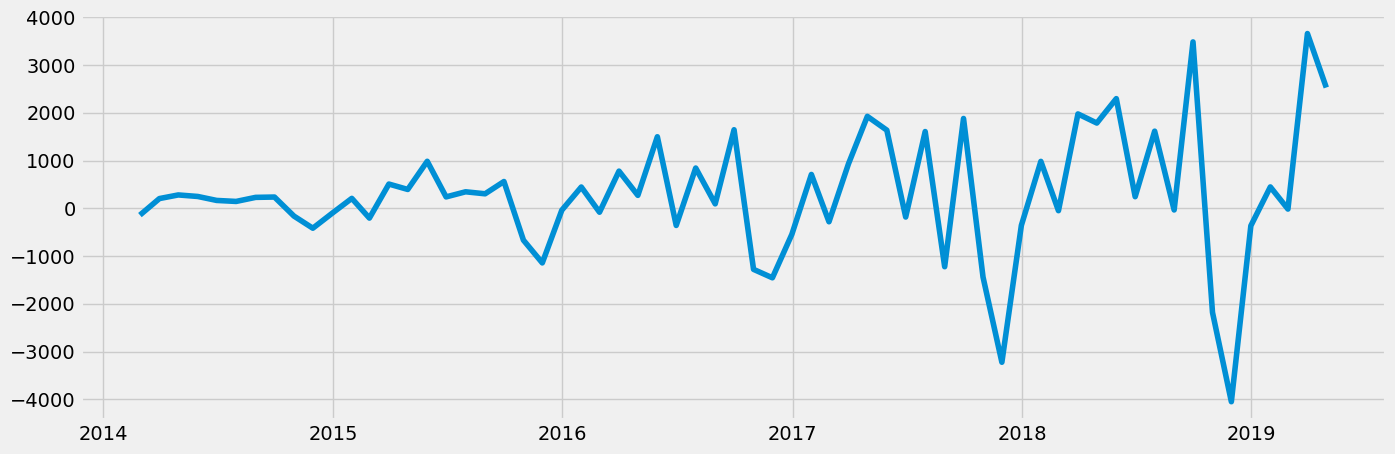

In [42]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [43]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  0.354684
p-value                         0.979719
Number of Lags Used            11.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


The Dickey-Fuller test after differentiating is better than before, but data still isn’t stationary and we need to perform another round of differencing.

In [44]:
data_diff_2 = data_diff - data_diff.shift(1)

In [45]:
data_diff_2.dropna(inplace = True)

In [46]:
data_diff_2.head()

,Reviews
datetime,
2014-03-31,346.0
2014-04-30,76.0
2014-05-31,-32.0
2014-06-30,-83.0
2014-07-31,-21.0


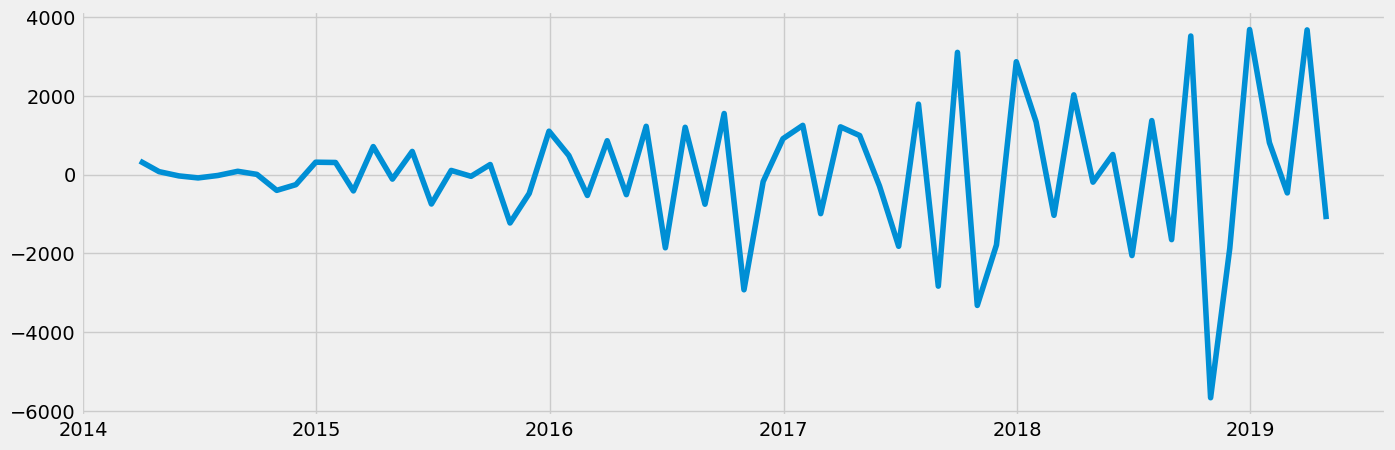

In [47]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [48]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.832939e+01
p-value                        2.257436e-30
Number of Lags Used            1.000000e+01
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


This second round gave us a better result, but we have over-differentiated the time series, which we can check with a test for autocorrelation. 

## Test for autocorrelation

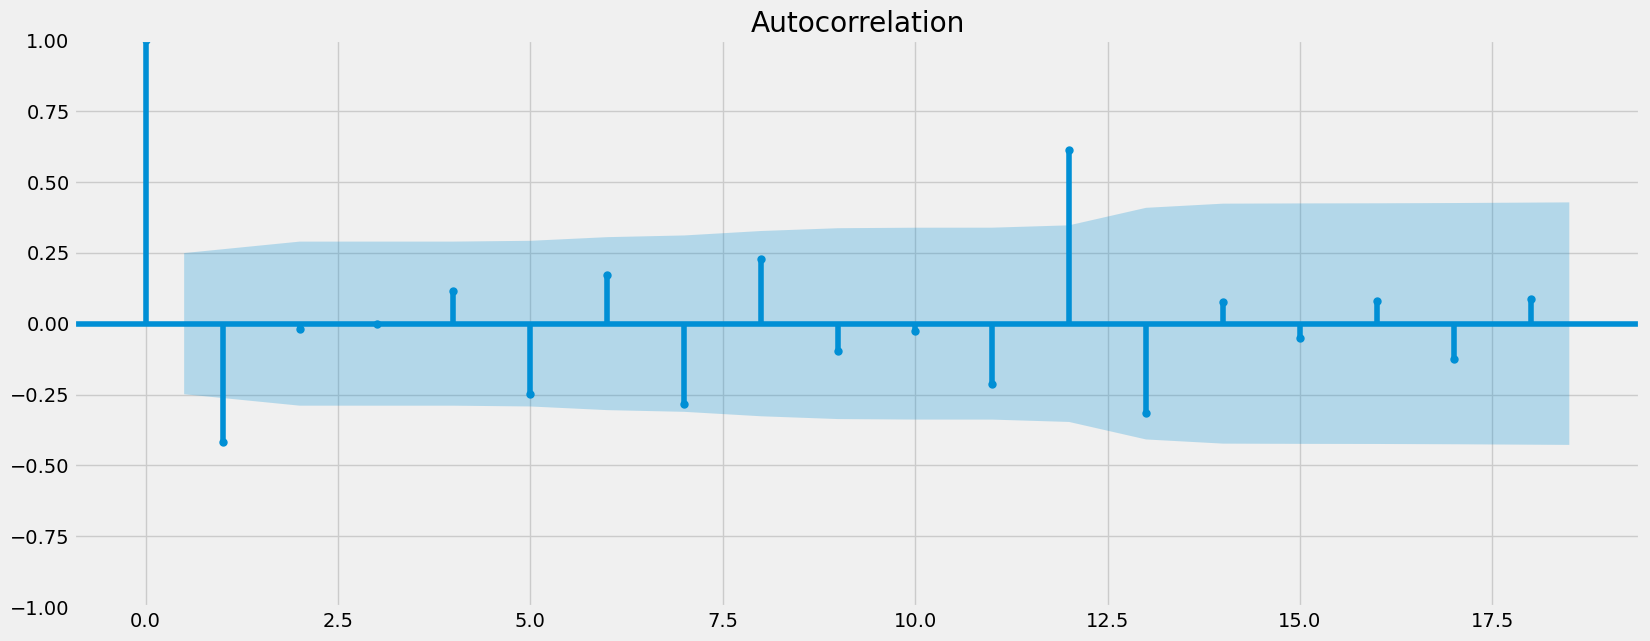

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff_2)
plt.show()

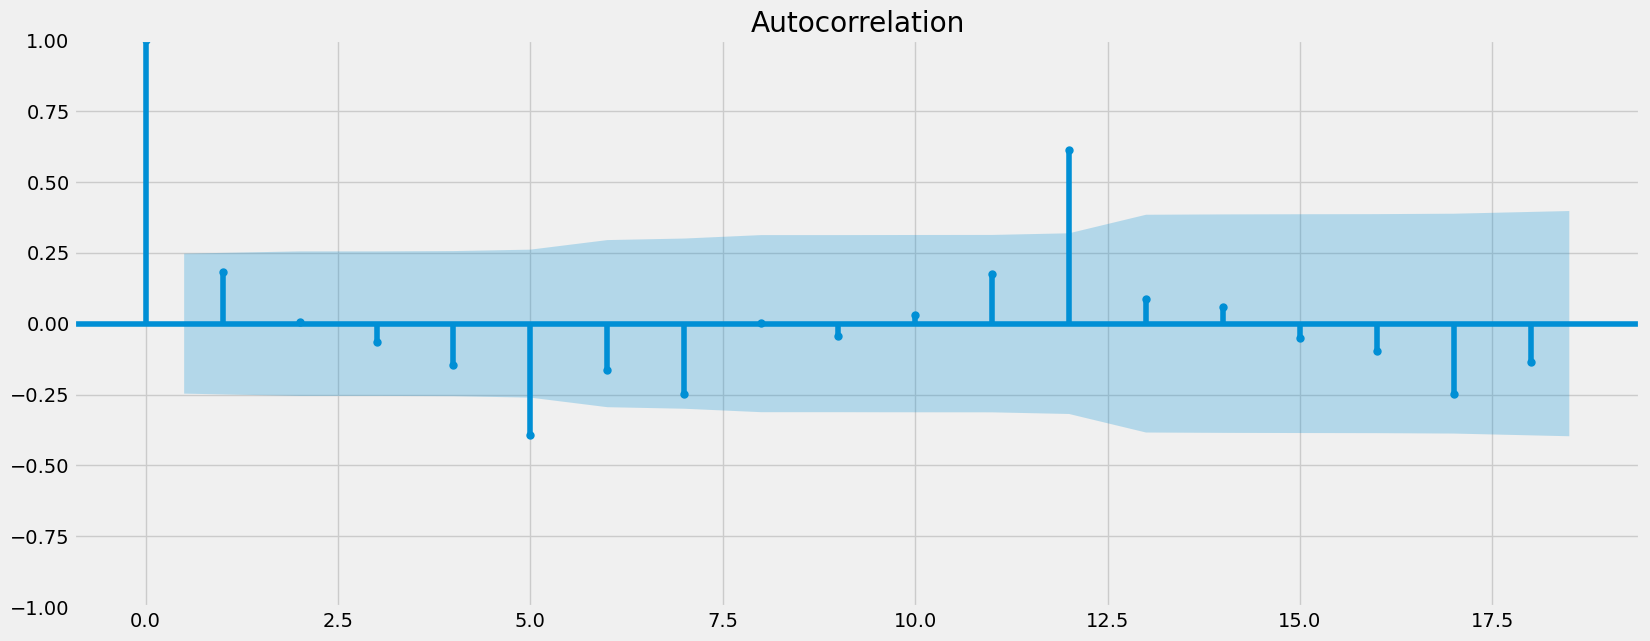

In [50]:
# Checking the autocorrelation with only the first round of differentiation

plot_acf(data_diff)
plt.show()

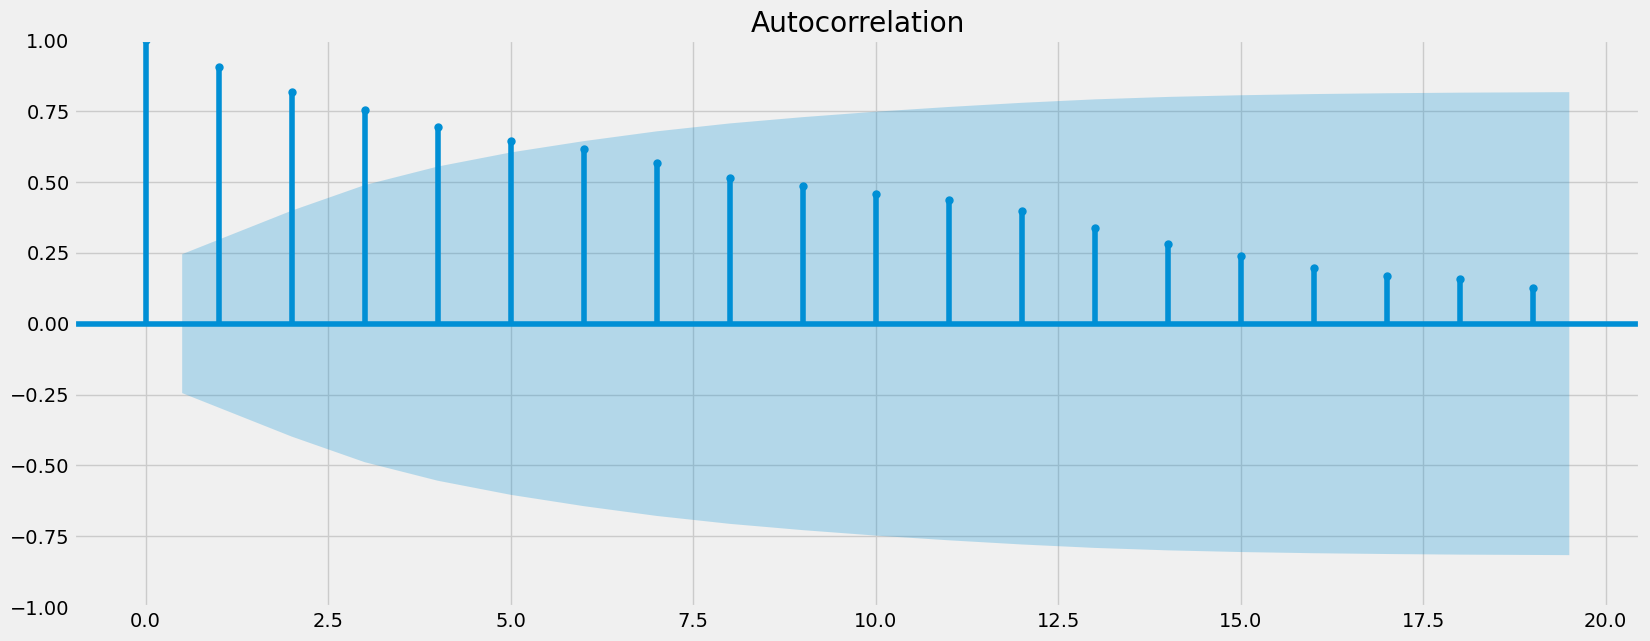

In [51]:
# Checking the autocorrelation of the data before differentiating

plot_acf(data_sub)
plt.show()

## Exporting the charts

In [53]:
time_series_reviews.figure.savefig(os.path.join(path, '4. Analysis','Visualizations', 'time_series_reviews.png'))